# Multi-Model Evaluation & Comparison

Compare green space detection models:
- **Random Forest (RF)**
- **Support Vector Machine (SVM)**
- **U-Net Deep Learning**

Against ground truth:
- **WorldCover 2021** (ESA satellite-derived land cover)
- **OSM** (OpenStreetMap crowd-sourced green spaces)
- **NDVI Filter** (simple vegetation index threshold)

Metrics: Accuracy, Precision, Recall, F1-Score, IoU, Dice

In [1]:
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, jaccard_score
)
from scipy.ndimage import median_filter
import joblib
import json
import os
import pandas as pd
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings('ignore')

# TensorFlow for U-Net (optional)
try:
    import tensorflow as tf
    from tensorflow import keras
    HAS_TENSORFLOW = True
    print(f"TensorFlow version: {tf.__version__}")
except ImportError:
    HAS_TENSORFLOW = False
    print("TensorFlow not available - U-Net evaluation will be skipped")

print("Libraries loaded!")

TensorFlow version: 2.20.0
Libraries loaded!


## 1. Configuration

In [2]:
# Test city (excluded from training)
CITY = "London"

# Paths
BASE_PATH = "/Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city"

# Data paths
STACK_PATH = os.path.join(BASE_PATH, "processed_stacks", f"{CITY}_MultiMonth_stack.tif")
WORLDCOVER_PATH = os.path.join(BASE_PATH, "WorldCover_Clipped", f"{CITY}_WorldCover_2021.tif")
OSM_PATH = os.path.join(BASE_PATH, "sentinel_data", CITY, f"{CITY}_OSM_labels.tif")
AOI_PATH = os.path.join(BASE_PATH, "aois_json", f"{CITY}.geojson")

# Model paths
RF_MODEL_PATH = os.path.join(BASE_PATH, "random_forest_model.pkl")
RF_SCALER_PATH = os.path.join(BASE_PATH, "feature_scaler.pkl")
SVM_MODEL_PATH = os.path.join(BASE_PATH, "svm_model.pkl")
SVM_SCALER_PATH = os.path.join(BASE_PATH, "svm_scaler.pkl")
UNET_MODEL_PATH = os.path.join(BASE_PATH, "unet_model.keras")
UNET_NORM_PATH = os.path.join(BASE_PATH, "unet_normalization_params.json")

# Output folder
OUTPUT_FOLDER = os.path.join(BASE_PATH, "multi_model_evaluation", CITY)
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Prediction settings
RF_THRESHOLD = 0.55
SVM_THRESHOLD = 0.5  # For probability-based SVM
UNET_THRESHOLD = 0.5
NDVI_THRESHOLD = 0.3
APPLY_SMOOTHING = True
UNET_PATCH_SIZE = 64
UNET_OVERLAP = 16

# WorldCover green classes
GREEN_CLASSES = [10, 20, 30]  # Tree, Shrubland, Grassland

print(f"Evaluating: {CITY}")
print(f"Output folder: {OUTPUT_FOLDER}")
print(f"\nModel availability:")
print(f"  RF:    {'Available' if os.path.exists(RF_MODEL_PATH) else 'Not found'}")
print(f"  SVM:   {'Available' if os.path.exists(SVM_MODEL_PATH) else 'Not found'}")
print(f"  U-Net: {'Available' if os.path.exists(UNET_MODEL_PATH) and HAS_TENSORFLOW else 'Not available'}")

Evaluating: London
Output folder: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/multi_model_evaluation/London

Model availability:
  RF:    Available
  SVM:   Available
  U-Net: Available


## 2. Load Data

In [3]:
# Load Sentinel-2 stack
print(f"Loading Sentinel-2 stack for {CITY}...")
with rasterio.open(STACK_PATH) as src:
    X_stack = src.read()
    profile = src.profile.copy()
    transform = src.transform
    crs = src.crs

n_bands, height, width = X_stack.shape
print(f"  Shape: {X_stack.shape} ({n_bands} bands, {height}x{width} pixels)")

Loading Sentinel-2 stack for London...
  Shape: (21, 512, 512) (21 bands, 512x512 pixels)


In [4]:
# Load WorldCover and reproject
print(f"\nLoading WorldCover...")
with rasterio.open(WORLDCOVER_PATH) as src:
    wc_data = src.read(1)
    wc_transform = src.transform
    wc_crs = src.crs

worldcover = np.empty((height, width), dtype=np.uint8)
reproject(
    source=wc_data,
    destination=worldcover,
    src_transform=wc_transform,
    src_crs=wc_crs,
    dst_transform=transform,
    dst_crs=crs,
    resampling=Resampling.nearest
)

worldcover_green = np.isin(worldcover, GREEN_CLASSES).astype(np.uint8)
wc_pct = 100 * worldcover_green.sum() / worldcover_green.size
print(f"  WorldCover green: {wc_pct:.2f}%")


Loading WorldCover...
  WorldCover green: 20.99%


In [5]:
# Load OSM labels
print(f"\nLoading OSM labels...")
if os.path.exists(OSM_PATH):
    with rasterio.open(OSM_PATH) as src:
        osm_data = src.read(1)
        osm_transform_src = src.transform
        osm_crs_src = src.crs
    
    if osm_data.shape != (height, width):
        osm_labels = np.empty((height, width), dtype=np.uint8)
        reproject(
            source=osm_data,
            destination=osm_labels,
            src_transform=osm_transform_src,
            src_crs=osm_crs_src,
            dst_transform=transform,
            dst_crs=crs,
            resampling=Resampling.nearest
        )
    else:
        osm_labels = osm_data
    
    osm_pct = 100 * osm_labels.sum() / osm_labels.size
    print(f"  OSM green: {osm_pct:.2f}%")
else:
    print("  OSM labels not found!")
    osm_labels = None
    osm_pct = None


Loading OSM labels...
  OSM green: 17.86%


## 3. Load Models

In [6]:
models = {}

# Load Random Forest
if os.path.exists(RF_MODEL_PATH) and os.path.exists(RF_SCALER_PATH):
    print("Loading Random Forest model...")
    rf_model = joblib.load(RF_MODEL_PATH)
    rf_scaler = joblib.load(RF_SCALER_PATH)
    models['RF'] = {'model': rf_model, 'scaler': rf_scaler}
    print(f"  RF loaded: {type(rf_model).__name__}")
else:
    print("  RF model not found")

# Load SVM
if os.path.exists(SVM_MODEL_PATH) and os.path.exists(SVM_SCALER_PATH):
    print("Loading SVM model...")
    svm_model = joblib.load(SVM_MODEL_PATH)
    svm_scaler = joblib.load(SVM_SCALER_PATH)
    models['SVM'] = {'model': svm_model, 'scaler': svm_scaler}
    print(f"  SVM loaded: {type(svm_model).__name__}")
else:
    print("  SVM model not found")

# Load U-Net
if HAS_TENSORFLOW and os.path.exists(UNET_MODEL_PATH):
    print("Loading U-Net model...")
    
    # Custom objects for U-Net
    def dice_coef(y_true, y_pred, smooth=1):
        y_true_f = tf.keras.backend.flatten(y_true)
        y_pred_f = tf.keras.backend.flatten(y_pred)
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

    def dice_loss(y_true, y_pred):
        return 1 - dice_coef(y_true, y_pred)

    def combined_loss(y_true, y_pred):
        return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    
    unet_model = keras.models.load_model(
        UNET_MODEL_PATH,
        custom_objects={'dice_coef': dice_coef, 'combined_loss': combined_loss}
    )
    models['U-Net'] = {'model': unet_model}
    print(f"  U-Net loaded")
else:
    print("  U-Net model not available")

print(f"\nModels loaded: {list(models.keys())}")

Loading Random Forest model...
  RF loaded: RandomForestClassifier
Loading SVM model...
  SVM loaded: SGDClassifier
Loading U-Net model...
  U-Net loaded

Models loaded: ['RF', 'SVM', 'U-Net']


## 4. Generate Predictions

In [7]:
predictions = {}
green_percentages = {'WorldCover': wc_pct}
if osm_pct is not None:
    green_percentages['OSM'] = osm_pct

# Prepare data for pixel-based models
X_flat = X_stack.reshape(n_bands, -1).T
valid_mask = ~np.isnan(X_flat).any(axis=1)
X_valid = X_flat[valid_mask]

In [8]:
# Random Forest prediction
if 'RF' in models:
    print("Generating RF prediction...")
    rf_model = models['RF']['model']
    rf_scaler = models['RF']['scaler']
    
    X_scaled = rf_scaler.transform(X_valid)
    
    # Use predict_proba if available
    if hasattr(rf_model, 'predict_proba'):
        y_proba = rf_model.predict_proba(X_scaled)
        y_pred = (y_proba[:, 1] >= RF_THRESHOLD).astype(int)
    else:
        y_pred = rf_model.predict(X_scaled)
    
    # Reconstruct full map
    rf_prediction = np.full(height * width, np.nan)
    rf_prediction[valid_mask] = y_pred
    rf_prediction = rf_prediction.reshape(height, width)
    
    # Apply smoothing
    if APPLY_SMOOTHING:
        nan_mask = np.isnan(rf_prediction)
        temp_map = np.where(nan_mask, 0, rf_prediction).astype(np.float32)
        temp_filtered = median_filter(temp_map, size=3)
        rf_prediction = np.where(nan_mask, np.nan, np.round(temp_filtered))
    
    predictions['RF'] = rf_prediction
    rf_pct = 100 * np.nansum(rf_prediction == 1) / np.sum(~np.isnan(rf_prediction))
    green_percentages['RF'] = rf_pct
    print(f"  RF green: {rf_pct:.2f}%")

Generating RF prediction...


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.2s


  RF green: 22.74%


[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    1.0s finished


In [9]:
# SVM prediction
if 'SVM' in models:
    print("Generating SVM prediction...")
    svm_model = models['SVM']['model']
    svm_scaler = models['SVM']['scaler']
    
    X_scaled = svm_scaler.transform(X_valid)
    
    # Use predict_proba if available (for SVC with probability=True)
    if hasattr(svm_model, 'predict_proba'):
        y_proba = svm_model.predict_proba(X_scaled)
        y_pred = (y_proba[:, 1] >= SVM_THRESHOLD).astype(int)
    else:
        y_pred = svm_model.predict(X_scaled)
    
    # Reconstruct full map
    svm_prediction = np.full(height * width, np.nan)
    svm_prediction[valid_mask] = y_pred
    svm_prediction = svm_prediction.reshape(height, width)
    
    # Apply smoothing
    if APPLY_SMOOTHING:
        nan_mask = np.isnan(svm_prediction)
        temp_map = np.where(nan_mask, 0, svm_prediction).astype(np.float32)
        temp_filtered = median_filter(temp_map, size=3)
        svm_prediction = np.where(nan_mask, np.nan, np.round(temp_filtered))
    
    predictions['SVM'] = svm_prediction
    svm_pct = 100 * np.nansum(svm_prediction == 1) / np.sum(~np.isnan(svm_prediction))
    green_percentages['SVM'] = svm_pct
    print(f"  SVM green: {svm_pct:.2f}%")

Generating SVM prediction...
  SVM green: 21.62%


In [10]:
# U-Net prediction
if 'U-Net' in models:
    print("Generating U-Net prediction...")
    unet_model = models['U-Net']['model']
    
    # Normalize image function
    def normalize_image(image):
        image = image.astype(np.float32)
        for c in range(image.shape[-1]):
            channel = image[:, :, c]
            min_val = np.nanmin(channel)
            max_val = np.nanmax(channel)
            if max_val > min_val:
                image[:, :, c] = (channel - min_val) / (max_val - min_val)
            else:
                image[:, :, c] = 0
        return image
    
    # Predict full image with sliding window
    def predict_full_image(model, image, patch_size=64, overlap=16):
        H, W, C = image.shape
        stride = patch_size - overlap
        
        # Pad image
        pad_h = (patch_size - H % stride) % stride
        pad_w = (patch_size - W % stride) % stride
        image_padded = np.pad(image, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')
        
        H_pad, W_pad, _ = image_padded.shape
        
        prediction_sum = np.zeros((H_pad, W_pad), dtype=np.float32)
        count = np.zeros((H_pad, W_pad), dtype=np.float32)
        
        image_norm = normalize_image(image_padded)
        
        for i in range(0, H_pad - patch_size + 1, stride):
            for j in range(0, W_pad - patch_size + 1, stride):
                patch = image_norm[i:i+patch_size, j:j+patch_size, :]
                patch_batch = np.expand_dims(patch, axis=0)
                
                pred = model.predict(patch_batch, verbose=0)[0, :, :, 0]
                
                prediction_sum[i:i+patch_size, j:j+patch_size] += pred
                count[i:i+patch_size, j:j+patch_size] += 1
        
        prediction = prediction_sum / np.maximum(count, 1)
        prediction = prediction[:H, :W]
        
        return prediction
    
    # Prepare image (H, W, C)
    X_image = X_stack.transpose(1, 2, 0)
    
    # Get probability map
    unet_proba = predict_full_image(
        unet_model, X_image,
        patch_size=UNET_PATCH_SIZE,
        overlap=UNET_OVERLAP
    )
    
    # Threshold to binary
    unet_prediction = (unet_proba >= UNET_THRESHOLD).astype(np.float32)
    
    # Apply smoothing
    if APPLY_SMOOTHING:
        unet_prediction = median_filter(unet_prediction, size=3)
        unet_prediction = np.round(unet_prediction)
    
    predictions['U-Net'] = unet_prediction
    unet_pct = 100 * unet_prediction.sum() / unet_prediction.size
    green_percentages['U-Net'] = unet_pct
    print(f"  U-Net green: {unet_pct:.2f}%")

Generating U-Net prediction...
  U-Net green: 1.71%


In [11]:
# NDVI Green Filter
print("\nCalculating NDVI Green Filter...")

def calculate_ndvi(nir, red):
    nir = nir.astype(float)
    red = red.astype(float)
    return (nir - red) / (nir + red + 1e-8)

# Band indices (21-band stack)
ndvi_april = calculate_ndvi(X_stack[3], X_stack[2])
ndvi_august = calculate_ndvi(X_stack[10], X_stack[9])
ndvi_november = calculate_ndvi(X_stack[17], X_stack[16])

ndvi_mean = np.nanmean(np.stack([ndvi_april, ndvi_august, ndvi_november]), axis=0)
green_filter = (ndvi_mean > NDVI_THRESHOLD).astype(np.uint8)

predictions['NDVI Filter'] = green_filter
gf_pct = 100 * green_filter.sum() / green_filter.size
green_percentages['NDVI Filter'] = gf_pct
print(f"  NDVI Filter (>{NDVI_THRESHOLD}): {gf_pct:.2f}%")


Calculating NDVI Green Filter...
  NDVI Filter (>0.3): 14.08%


## 5. Calculate Metrics

In [12]:
def calculate_metrics(y_true, y_pred, name):
    """Calculate classification metrics."""
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    valid = ~(np.isnan(y_true_flat) | np.isnan(y_pred_flat))
    y_true_clean = y_true_flat[valid].astype(int)
    y_pred_clean = y_pred_flat[valid].astype(int)
    
    metrics = {
        'Method': name,
        'Accuracy': accuracy_score(y_true_clean, y_pred_clean),
        'Precision': precision_score(y_true_clean, y_pred_clean, zero_division=0),
        'Recall': recall_score(y_true_clean, y_pred_clean, zero_division=0),
        'F1-Score': f1_score(y_true_clean, y_pred_clean, zero_division=0),
        'IoU': jaccard_score(y_true_clean, y_pred_clean, zero_division=0),
        'Pred Green %': 100 * y_pred_clean.sum() / len(y_pred_clean),
        'GT Green %': 100 * y_true_clean.sum() / len(y_true_clean),
        'Diff %': 100 * (y_pred_clean.sum() - y_true_clean.sum()) / len(y_true_clean)
    }
    
    return metrics, confusion_matrix(y_true_clean, y_pred_clean)

In [13]:
# Calculate all metrics
results = []
confusion_matrices = {}

# Each model vs WorldCover
for model_name, pred in predictions.items():
    metrics, cm = calculate_metrics(worldcover_green, pred, f'{model_name} vs WorldCover')
    results.append(metrics)
    confusion_matrices[f'{model_name} vs WorldCover'] = cm

# Each model vs OSM (if available)
if osm_labels is not None:
    for model_name, pred in predictions.items():
        metrics, cm = calculate_metrics(osm_labels, pred, f'{model_name} vs OSM')
        results.append(metrics)
        confusion_matrices[f'{model_name} vs OSM'] = cm

# Create DataFrame
df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

                   Method  Accuracy  Precision   Recall  F1-Score      IoU  Pred Green %  GT Green %     Diff %
         RF vs WorldCover  0.946012   0.843062 0.912854  0.876571 0.780264     22.739333   21.000813   1.738520
        SVM vs WorldCover  0.934578   0.834422 0.858919  0.846494 0.733844     21.617350   21.000813   0.616537
      U-Net vs WorldCover  0.807007   0.995304 0.080895  0.149629 0.080864      1.705933   20.989227 -19.283295
NDVI Filter vs WorldCover  0.917484   0.952244 0.638908  0.764724 0.619072     14.082718   20.989227  -6.906509
                RF vs OSM  0.895051   0.662251 0.842525  0.741590 0.589307     22.739333   17.873845   4.865488
               SVM vs OSM  0.899438   0.680818 0.823409  0.745355 0.594076     21.617350   17.873845   3.743505
             U-Net vs OSM  0.837147   0.962433 0.091913  0.167801 0.091584      1.705933   17.863083 -16.157150
       NDVI Filter vs OSM  0.909988   0.814638 0.642236  0.718237 0.560350     14.082718   17.863083  -3

In [14]:
# Save metrics
df_results.to_csv(os.path.join(OUTPUT_FOLDER, 'metrics_comparison.csv'), index=False)
print(f"\nMetrics saved to: {OUTPUT_FOLDER}/metrics_comparison.csv")


Metrics saved to: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/multi_model_evaluation/London/metrics_comparison.csv


## 6. Visualizations

In [15]:
# Prepare RGB
rgb = X_stack[[9, 8, 7], :, :].transpose(1, 2, 0)
rgb_norm = np.clip(rgb / 3000, 0, 1)

# Colormap for predictions
cmap_green = plt.cm.RdYlGn.copy()
cmap_green.set_bad(color='gray')

# Difference colormap: gray, red, blue, green
diff_cmap = ListedColormap(['#808080', '#FF6B6B', '#4DABF7', '#51CF66'])

def create_diff_map(pred, gt):
    pred = np.nan_to_num(pred, nan=0).astype(int)
    gt = gt.astype(int)
    diff = np.zeros_like(pred)
    diff[(pred == 0) & (gt == 0)] = 0  # True Negative
    diff[(pred == 1) & (gt == 0)] = 1  # False Positive
    diff[(pred == 0) & (gt == 1)] = 2  # False Negative
    diff[(pred == 1) & (gt == 1)] = 3  # True Positive
    return diff

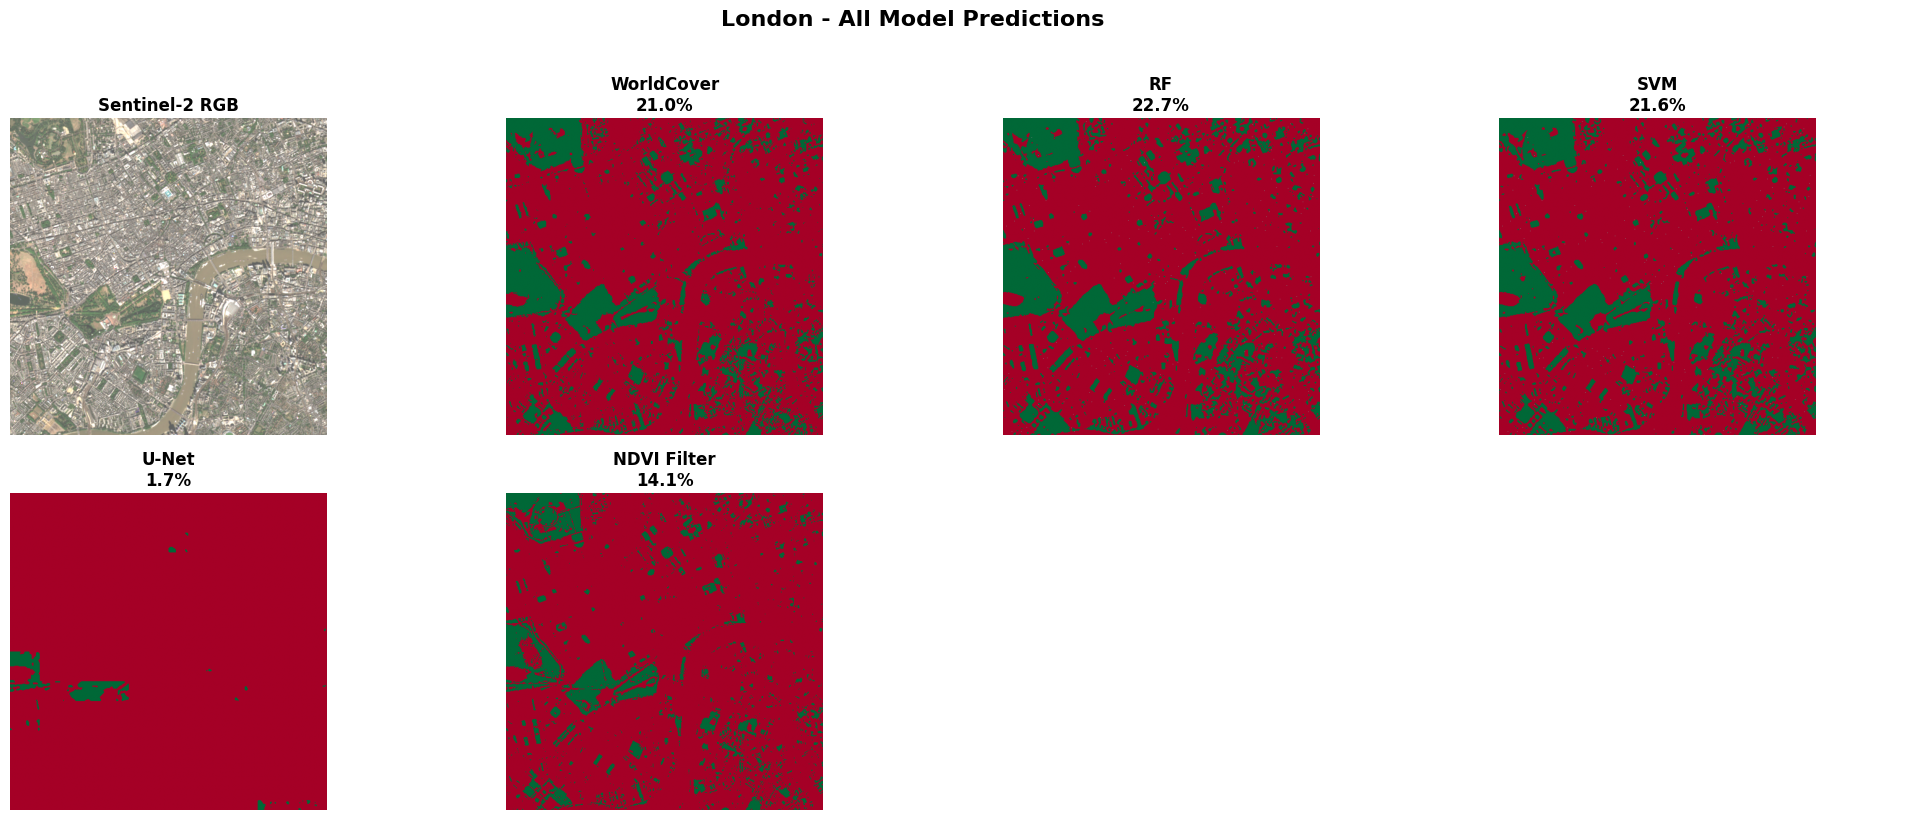

In [16]:
# Main comparison grid - all predictions
n_models = len(predictions)
n_cols = min(n_models + 2, 4)  # +2 for RGB and WorldCover
n_rows = int(np.ceil((n_models + 2) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten() if n_rows * n_cols > 1 else [axes]

# RGB
axes[0].imshow(rgb_norm)
axes[0].set_title('Sentinel-2 RGB', fontsize=12, fontweight='bold')
axes[0].axis('off')

# WorldCover
axes[1].imshow(worldcover_green, cmap='RdYlGn', vmin=0, vmax=1)
axes[1].set_title(f'WorldCover\n{wc_pct:.1f}%', fontsize=12, fontweight='bold')
axes[1].axis('off')

# Each model prediction
for i, (model_name, pred) in enumerate(predictions.items()):
    ax = axes[i + 2]
    pred_masked = np.ma.masked_invalid(pred)
    ax.imshow(pred_masked, cmap=cmap_green, vmin=0, vmax=1)
    ax.set_title(f'{model_name}\n{green_percentages[model_name]:.1f}%', fontsize=12, fontweight='bold')
    ax.axis('off')

# Hide unused axes
for i in range(n_models + 2, len(axes)):
    axes[i].axis('off')

plt.suptitle(f'{CITY} - All Model Predictions', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, 'all_predictions.png'), dpi=300, bbox_inches='tight')
plt.show()

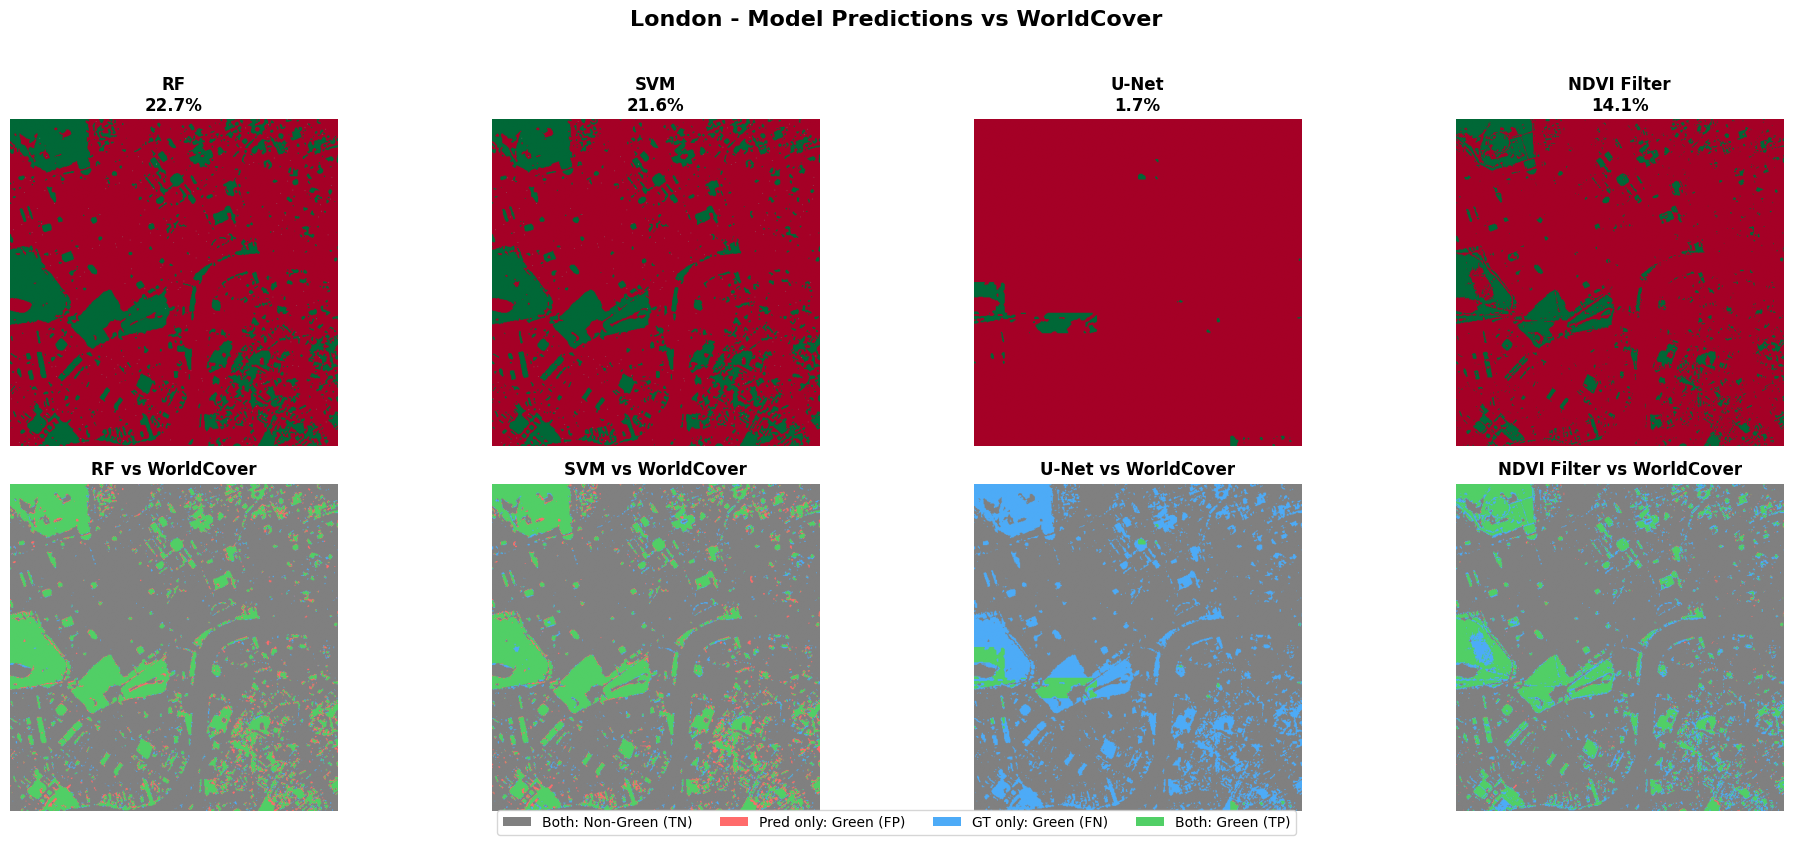

In [17]:
# Difference maps vs WorldCover
n_models = len(predictions)
fig, axes = plt.subplots(2, max(n_models, 3), figsize=(5*max(n_models, 3), 8))

# Row 1: Predictions
for i, (model_name, pred) in enumerate(predictions.items()):
    pred_masked = np.ma.masked_invalid(pred)
    axes[0, i].imshow(pred_masked, cmap=cmap_green, vmin=0, vmax=1)
    axes[0, i].set_title(f'{model_name}\n{green_percentages[model_name]:.1f}%', fontsize=12, fontweight='bold')
    axes[0, i].axis('off')

# Row 2: Difference maps
for i, (model_name, pred) in enumerate(predictions.items()):
    diff_map = create_diff_map(pred, worldcover_green)
    axes[1, i].imshow(diff_map, cmap=diff_cmap, vmin=0, vmax=3)
    axes[1, i].set_title(f'{model_name} vs WorldCover', fontsize=12, fontweight='bold')
    axes[1, i].axis('off')

# Hide unused axes
for i in range(n_models, max(n_models, 3)):
    axes[0, i].axis('off')
    axes[1, i].axis('off')

# Legend
legend_elements = [
    Patch(facecolor='#808080', label='Both: Non-Green (TN)'),
    Patch(facecolor='#FF6B6B', label='Pred only: Green (FP)'),
    Patch(facecolor='#4DABF7', label='GT only: Green (FN)'),
    Patch(facecolor='#51CF66', label='Both: Green (TP)')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=4, fontsize=10, bbox_to_anchor=(0.5, -0.02))

plt.suptitle(f'{CITY} - Model Predictions vs WorldCover', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, 'difference_maps_worldcover.png'), dpi=300, bbox_inches='tight')
plt.show()

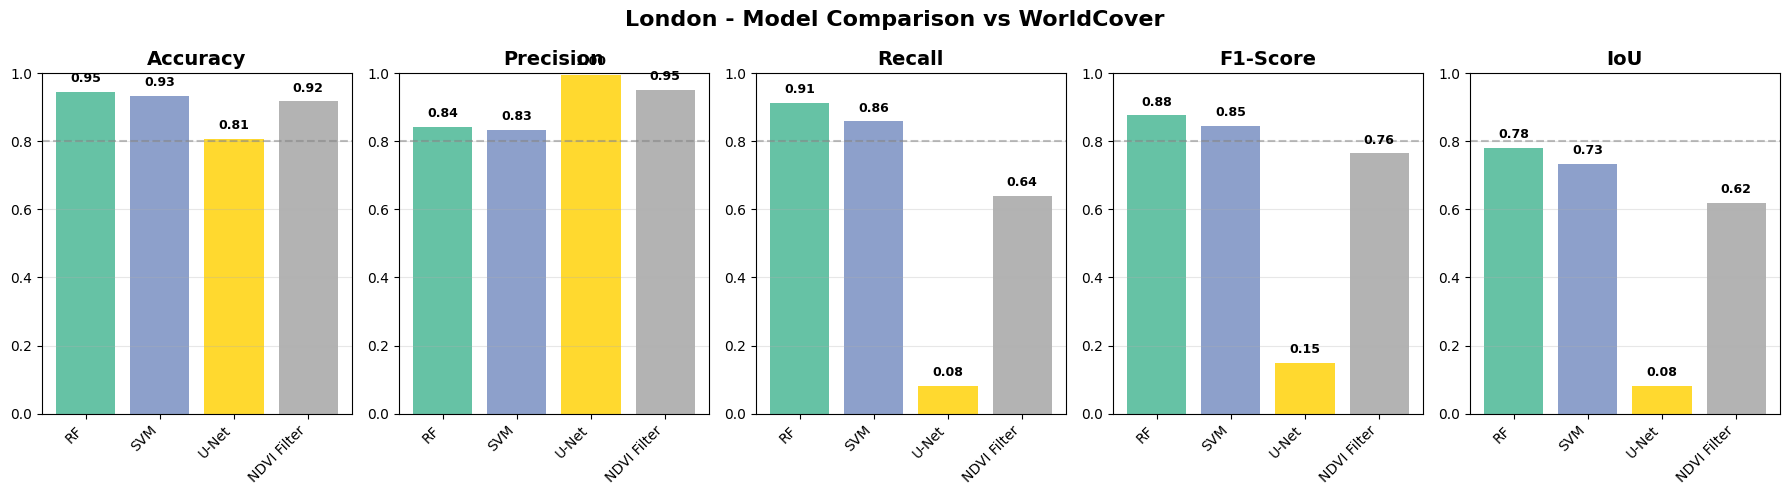

In [18]:
# Metrics bar charts - vs WorldCover only
df_wc = df_results[df_results['Method'].str.contains('WorldCover')].copy()
df_wc['Model'] = df_wc['Method'].str.replace(' vs WorldCover', '')

fig, axes = plt.subplots(1, 5, figsize=(18, 5))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'IoU']
colors = plt.cm.Set2(np.linspace(0, 1, len(df_wc)))

for i, metric in enumerate(metrics_to_plot):
    bars = axes[i].bar(range(len(df_wc)), df_wc[metric], color=colors)
    axes[i].set_xticks(range(len(df_wc)))
    axes[i].set_xticklabels(df_wc['Model'], rotation=45, ha='right', fontsize=10)
    axes[i].set_title(metric, fontsize=14, fontweight='bold')
    axes[i].set_ylim(0, 1)
    axes[i].axhline(y=0.8, color='gray', linestyle='--', alpha=0.5)
    axes[i].grid(axis='y', alpha=0.3)
    
    for bar, val in zip(bars, df_wc[metric]):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                    f'{val:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle(f'{CITY} - Model Comparison vs WorldCover', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, 'metrics_comparison_barchart.png'), dpi=300, bbox_inches='tight')
plt.show()

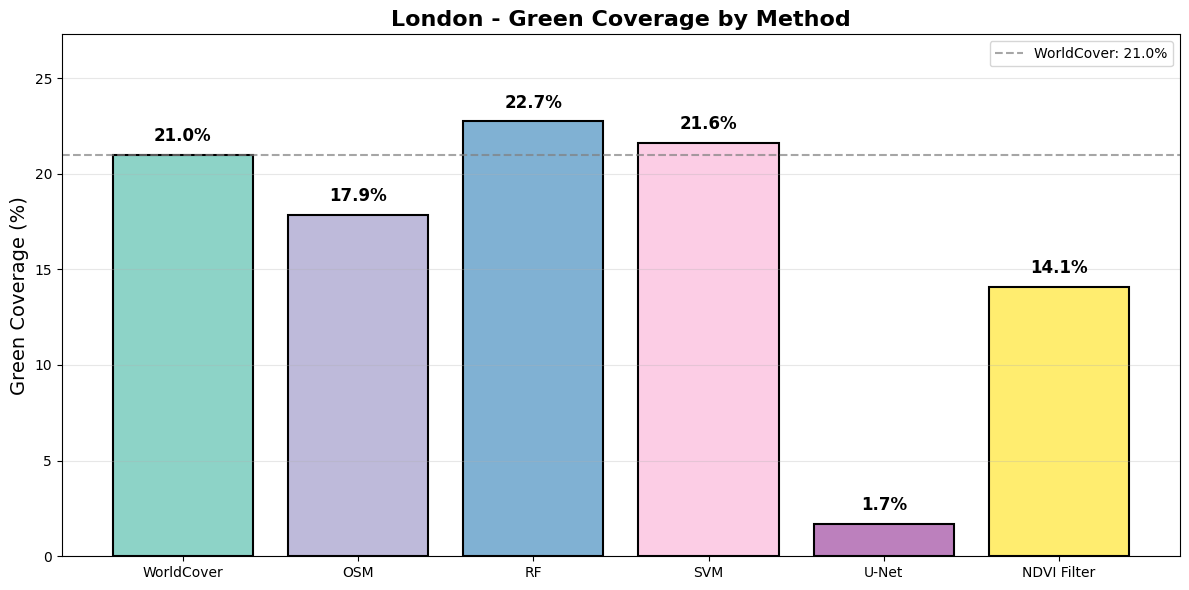

In [19]:
# Green coverage comparison
fig, ax = plt.subplots(figsize=(12, 6))

methods = list(green_percentages.keys())
percentages = list(green_percentages.values())
colors = plt.cm.Set3(np.linspace(0, 1, len(methods)))

bars = ax.bar(methods, percentages, color=colors, edgecolor='black', linewidth=1.5)

for bar, pct in zip(bars, percentages):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{pct:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Green Coverage (%)', fontsize=14)
ax.set_title(f'{CITY} - Green Coverage by Method', fontsize=16, fontweight='bold')
ax.set_ylim(0, max(percentages) * 1.2)
ax.axhline(y=wc_pct, color='gray', linestyle='--', alpha=0.7, label=f'WorldCover: {wc_pct:.1f}%')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, 'green_coverage_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

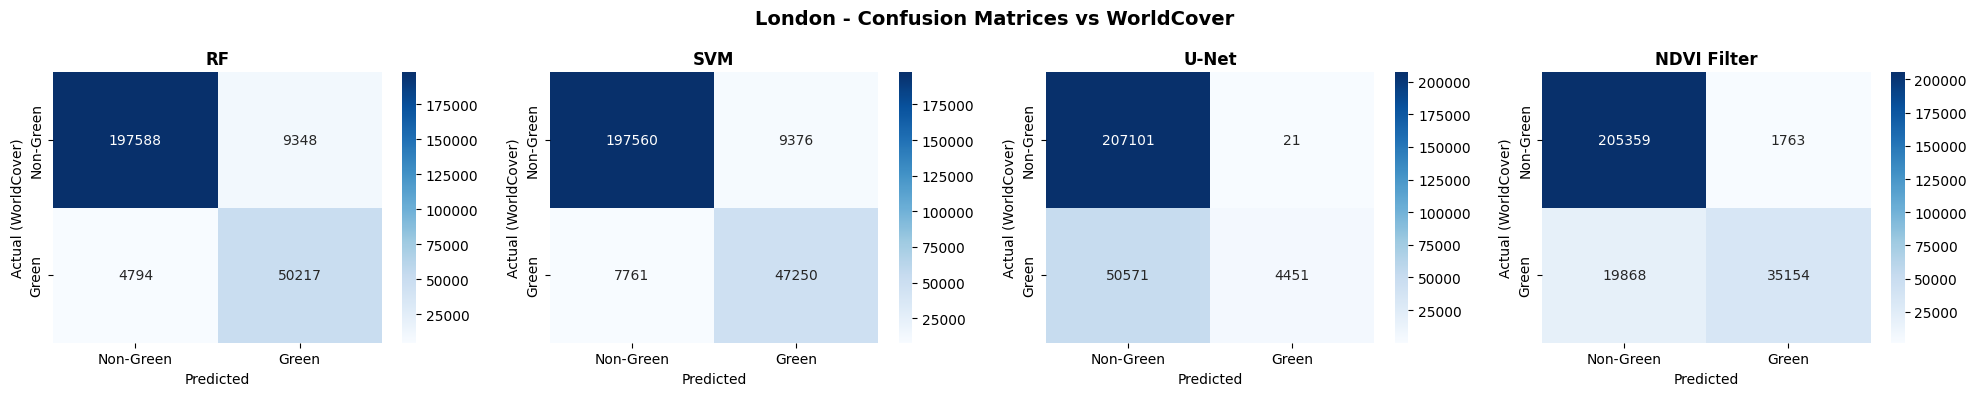

In [20]:
# Confusion matrices - vs WorldCover
wc_cms = {k: v for k, v in confusion_matrices.items() if 'WorldCover' in k}
n_cms = len(wc_cms)

fig, axes = plt.subplots(1, n_cms, figsize=(5*n_cms, 4))
if n_cms == 1:
    axes = [axes]

for ax, (name, cm) in zip(axes, wc_cms.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Non-Green', 'Green'],
                yticklabels=['Non-Green', 'Green'])
    ax.set_title(name.replace(' vs WorldCover', ''), fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual (WorldCover)')

plt.suptitle(f'{CITY} - Confusion Matrices vs WorldCover', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, 'confusion_matrices_worldcover.png'), dpi=300, bbox_inches='tight')
plt.show()

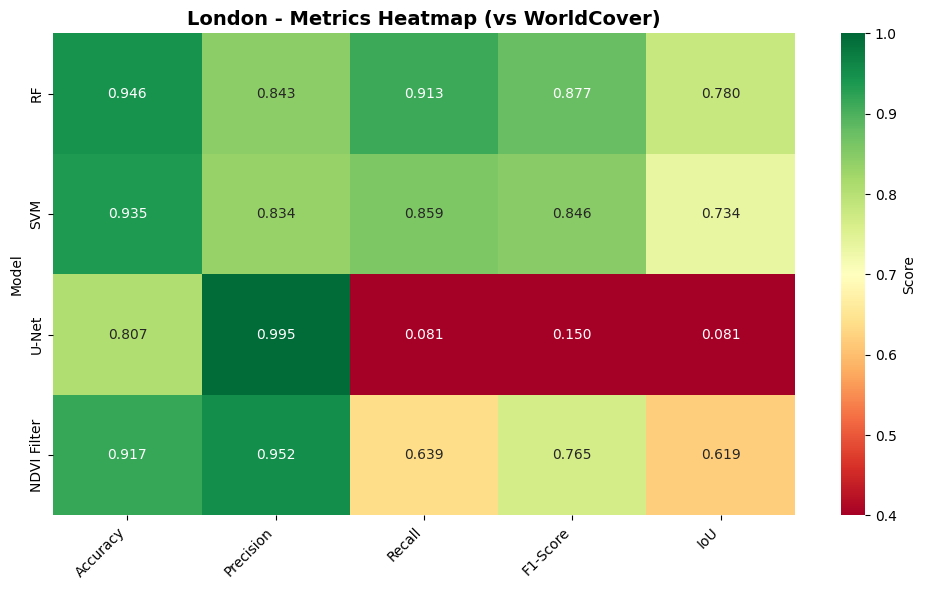

In [21]:
# Heatmap of all metrics
df_wc_metrics = df_wc[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'IoU']].set_index('Model')

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df_wc_metrics, annot=True, fmt='.3f', cmap='RdYlGn', 
            vmin=0.4, vmax=1.0, ax=ax, cbar_kws={'label': 'Score'})
ax.set_title(f'{CITY} - Metrics Heatmap (vs WorldCover)', fontsize=14, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, 'metrics_heatmap.png'), dpi=300, bbox_inches='tight')
plt.show()

## 7. Summary Report

In [22]:
print("="*80)
print(f"MULTI-MODEL EVALUATION SUMMARY - {CITY}")
print("="*80)

print(f"\nGreen Coverage:")
for method, pct in green_percentages.items():
    diff = pct - wc_pct if method != 'WorldCover' else 0
    print(f"  {method:20s}: {pct:6.2f}%" + (f"  (diff: {diff:+.2f}%)" if diff != 0 else ""))

print(f"\nModel Performance vs WorldCover:")
print(f"  {'Model':<15} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'IoU':>10}")
print(f"  {'-'*65}")
for _, row in df_wc.iterrows():
    print(f"  {row['Model']:<15} {row['Accuracy']:>10.4f} {row['Precision']:>10.4f} {row['Recall']:>10.4f} {row['F1-Score']:>10.4f} {row['IoU']:>10.4f}")

# Find best model
best_f1_model = df_wc.loc[df_wc['F1-Score'].idxmax(), 'Model']
best_f1_score = df_wc['F1-Score'].max()
print(f"\nBest Model (F1-Score): {best_f1_model} ({best_f1_score:.4f})")

print(f"\nOutput Files:")
print(f"  {OUTPUT_FOLDER}/")
for f in os.listdir(OUTPUT_FOLDER):
    print(f"    - {f}")

print("="*80)

MULTI-MODEL EVALUATION SUMMARY - London

Green Coverage:
  WorldCover          :  20.99%
  OSM                 :  17.86%  (diff: -3.13%)
  RF                  :  22.74%  (diff: +1.75%)
  SVM                 :  21.62%  (diff: +0.63%)
  U-Net               :   1.71%  (diff: -19.28%)
  NDVI Filter         :  14.08%  (diff: -6.91%)

Model Performance vs WorldCover:
  Model             Accuracy  Precision     Recall   F1-Score        IoU
  -----------------------------------------------------------------
  RF                  0.9460     0.8431     0.9129     0.8766     0.7803
  SVM                 0.9346     0.8344     0.8589     0.8465     0.7338
  U-Net               0.8070     0.9953     0.0809     0.1496     0.0809
  NDVI Filter         0.9175     0.9522     0.6389     0.7647     0.6191

Best Model (F1-Score): RF (0.8766)

Output Files:
  /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/multi_model_evaluation/London/
    - all_predictions.png
    - metrics_comparison.csv
    -

In [23]:
# Save summary to JSON
summary = {
    "city": CITY,
    "models_evaluated": list(predictions.keys()),
    "green_percentages": green_percentages,
    "metrics_vs_worldcover": df_wc.to_dict(orient='records'),
    "best_model": {
        "name": best_f1_model,
        "f1_score": float(best_f1_score)
    },
    "settings": {
        "rf_threshold": RF_THRESHOLD,
        "svm_threshold": SVM_THRESHOLD,
        "unet_threshold": UNET_THRESHOLD,
        "ndvi_threshold": NDVI_THRESHOLD,
        "smoothing": APPLY_SMOOTHING
    }
}

with open(os.path.join(OUTPUT_FOLDER, 'evaluation_summary.json'), 'w') as f:
    json.dump(summary, f, indent=2)

print(f"Summary saved to: {OUTPUT_FOLDER}/evaluation_summary.json")

TypeError: Object of type float32 is not JSON serializable